In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import cv2 as cv
import glob
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from mpl_toolkits.mplot3d import Axes3D

input_folder="Photos/"

# 3. Obtener siluetas de un conjunto de imágenes

Una vez realizado la toma de imágenes detectando la posición y rotación de la cámara, el siguiente paso será **obtener las siluetas de las mismas.** Para hacer esto, se seguiran los siguientes pasos:

- 1º **Transformar imagen a niveles de grises:**De la imagen original, se pasa a escala de grises. También tenemos la opción de recortar la imagen para centrar la figura si utilizamos apply_trim



- 2º **Eliminar ruido de la imagen gris:** Para este filtrado, se prefirió utilizar un filtrado de suavizado por media, ya que devolvía mejores resultados que el suavizado por Gauss. Se aplica una máscara 11x11.



- 3º **Obtener imagen umbralizada:** Aplicando la umbralización binaria y la de Otsu, generamos la imagen binarizada. En caso de que nuestra figura presente agujeros, se generará otra imagen umbralizada a partir de la umbralización adaptativa para generar los contornos.



- 4º **Capturar contornos de imagen umbralizada:** Generamos los contornos que hemos capturado a partir del método Canny. En este paso tenemos dos alternativas:

     - Si la figura de la imagen no presenta agujeros, **no se interpreta ninguna jerarquía**, por lo que se rellenarán todos los contornos sin seguir ninguna jerarquía.
     - Si la figura de la imagen presenta agujeros, **se define una jerarquía**, por lo que a la hora de rellenar, rellenará los contornos exteriores y vaciará los contornos interiores.


- 4º **Aplicar Operación morfológica de erosión y cierre para unir y rellenar contornos:** Una vez capturado los contornos, se aplicará un elemento estructural elíptico en las siguientes operaciones:
    - 1ºErosionar la imagen umbralizada para eliminar ruido de umbralización.
    - 2ºCierre de la imagen erosionada para unir los contornos
    - 3ºUna vez hecho estas operaciones, se rellenan los contornos y se devuelve la silueta capturada



- 5º **EXTRA: Operación OR entre contorno rellenado y NOT(imagen binarizada)**:  En caso de que la figura presente agujeros, es necesario aplicar luego una operación OR entre el contorno rellenado del anterior paso y la imagen binarizada. Habrá que negar la imagen binarizada (poner los 1 a 0 y viceversa aplicando bitwise_not) para realizar correctamente ñla operación.


**Resultado:** Se obtiene la silueta de la figura, sin importar que presente agujeros o no.

In [12]:
"""
Para facilitar el procesamiento de las imagenes, tenemos la opción de escalar la imagen con un porcentaje del margen
a quitar (trim_image) y la función de realce de laplance (enhance_laplance) para realzar las imagenes
"""
def trim_image(image,margen):
        gris = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        #margen=0.16
        color = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        h=color.shape[0]
        w=color.shape[1]
        margen_h=int(h*margen)
        margen_w=int(w*margen)
        color=color[int(h/2)-margen_h:int(h/2)+margen_h,int(w/2)-margen_w:int(w/2)+margen_w]
        image = color
        return image
def enhanced_laplance(imagen):
    laplacian = cv.Laplacian(imagen, cv.CV_64F)

    # Convertir a uint8 desde float
    laplacian = np.uint8(np.absolute(laplacian))
    imagen=imagen-laplacian
    return imagen

#----------------------------------------------------------------------------------------------

"""
    Se seguirán los siguientes pasos para obtener las siluetas:
"""


#1º Tomamos el conjunto de imágenes y las procesaremos individualmente cada una.
def get_silhouettes_from_input_folder(input_folder_location,apply_trim=False,has_holes=False):
    """
    Función que se encarga de obtener de un conjunto de imagenes el conjunto de siluetas.
    
    Parámetros:
    input_folder_location: string, ruta de la carpeta de imagenes
    apply_trim: bool, indicar si quieres realizar un recorte manual a la imagen o no.
    has_holes: bool, indicar si presenta agujeros la figura captura o no.
    
    
    """
    silhouettes=[]
    content = os.listdir(input_folder_location)
    extensions=[".jpg",".png",".jpeg"]
    for file in content:
        if os.path.isfile(os.path.join(input_folder_location,file)) and os.path.splitext(file)[1].lower() in extensions:
            #2ºPara cada imagen, se le obtendrá la silueta de la figura y luego guardarla.
            sil=get_silhouette_from_image(os.path.join(input_folder_location,file),apply_trim,has_holes)
            silhouettes.append(sil)
    return silhouettes


def get_silhouette_from_image(input_image,apply_trim=False,has_holes=False):
    
    #1ºTransformar imagen a niveles de grises:
    original = cv.imread(cv.samples.findFile(input_image))
    #En caso de necesitar escalar la imagen, aplicar apply_trim=true
    if(apply_trim):
        original=trim_image(original,margen=0.16)

    gris = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
    
    #2ºEliminar ruido de la imagen gris:
    median = cv.medianBlur(gris,11)
    
    #3ºObtener imagen umbralizada:
    _, imagen_binaria = cv.threshold(median, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.imshow(imagen_binaria,cmap="gray")
    imagen_binaria = imagen_binaria.astype(np.uint8)
    plt.title('1º IMAGEN BINARIZADA')
    plt.figure()
    th2=median
    if(has_holes):
        th2 = cv.adaptiveThreshold(median,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
        cv.THRESH_BINARY,11,2)
        plt.imshow(th2,cmap="gray")
        plt.title('2º IMAGEN UMBRALIZADA PARA CONTORNOS')
        plt.figure()
        
    
    plt.imshow(median,cmap="gray")
    plt.title('3º Suavizado')
    plt.figure()

    #4º Capturar contornos
    canny = cv.Canny(th2, 0, 150)
    
    if(has_holes):
        retr_method=cv.RETR_CCOMP
    else:
        retr_method=cv.RETR_EXTERNAL
    
    (contornos,jerarquias) = cv.findContours(canny.copy(), retr_method, cv.CHAIN_APPROX_NONE)
    black_background = np.zeros_like(original)
    cv.drawContours(black_background, contornos, -1, (255,255,255), -1)
    plt.imshow(black_background,cmap="gray")
    plt.title('4ºContorno capturado')
    plt.figure()
    
    #5º Aplicar Operación morfológica de erosión y cierre para unir y rellenar contornos
    kernel =cv.getStructuringElement(cv.MORPH_CROSS,(3,3))
    erosionada = cv.morphologyEx(canny, cv.MORPH_TOPHAT, kernel)
    kernel1 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    imagen_cerrada = cv.morphologyEx(erosionada, cv.MORPH_CLOSE, kernel1)
    (contornos,_) = cv.findContours(imagen_cerrada.copy(), retr_method, cv.CHAIN_APPROX_NONE)
    black_background = np.zeros_like(original,dtype=np.uint8)
    cv.drawContours(black_background, contornos, -1,(255,255,255), -1)
    plt.imshow(black_background)
    plt.title('5ºContorno cerrado y rellenado')
    plt.figure()
    
    
    #6º Extra: Operación OR entre contorno rellenado y NOT(imagen binarizada)
    black_background = black_background.astype(np.uint8)
    black_background = cv.cvtColor(black_background, cv.COLOR_BGR2GRAY)
    notbinary=cv.bitwise_not(imagen_binaria)
    notbinary=notbinary.astype(np.uint8)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20))
    clean = cv.morphologyEx(notbinary, cv.MORPH_CLOSE, kernel)
    if notbinary.shape == black_background.shape:
        orr = cv.bitwise_or(clean, black_background)
        plt.imshow(orr, cmap="gray")
        plt.title('6º Operación OR de Contorno e Imagen binarizada')
        plt.figure()
    else:
        print("Error: Las dimensiones de las imágenes no coinciden.")

    return orr




In [ ]:
for i, jerarquia in enumerate(jerarquias[0]):
    # jerarquia[3] es el índice del contorno padre; si es 0 o -1, es un contorno de nivel superior
    if jerarquia[3] == 0:
        # Rellena el contorno de nivel 1
        cv2.drawContours(imagen, contornos, i, (0,255,0), thickness=-1)

# PRUEBAS SOBRE TAZAS

**Estudio de los resultados:**
- No importa el color del objeto, la silueta devuelta proporciona una aproximación del objeto de interes.
- TIPOS DE DETECCIÓN DE CONTORNOS: https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga819779b9857cc2f8601e6526a3a5bc71


C:\Users\andre\AppData\Local\Temp\ipykernel_16108\568789106.py:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


5

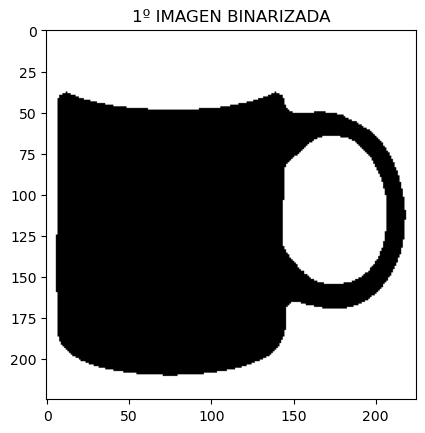

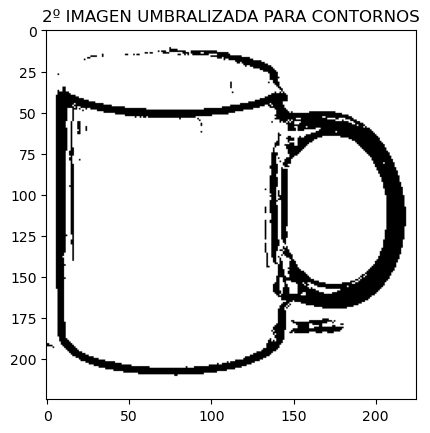

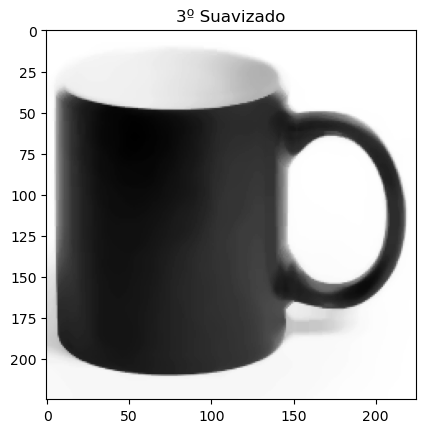

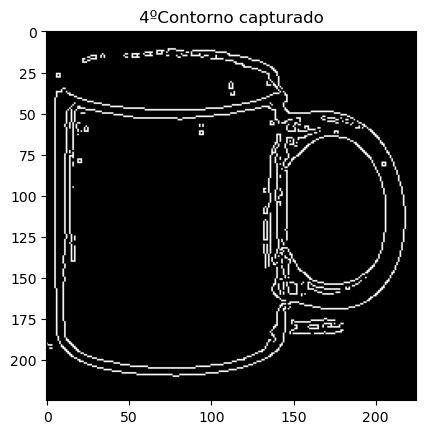

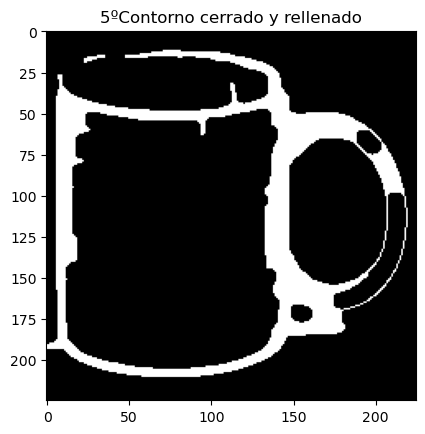

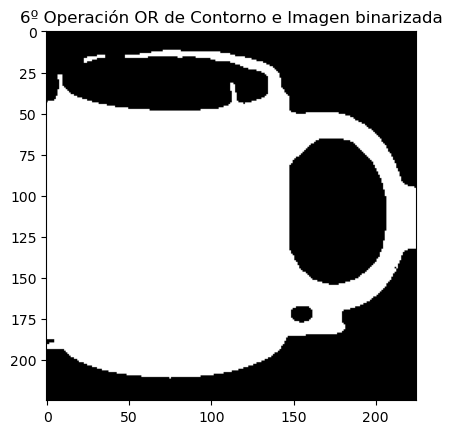

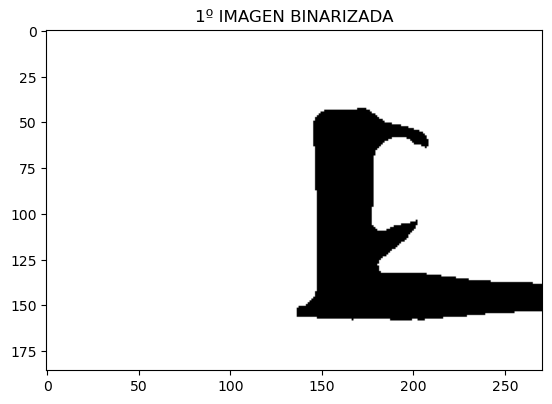

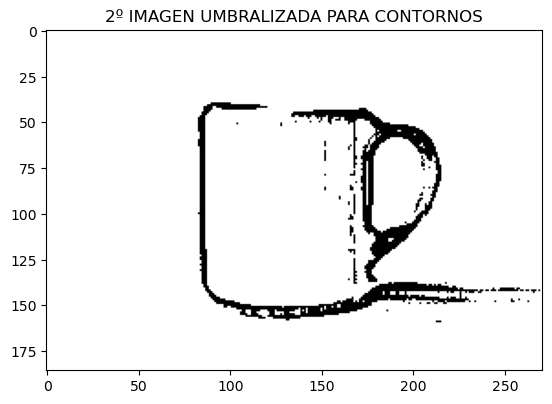

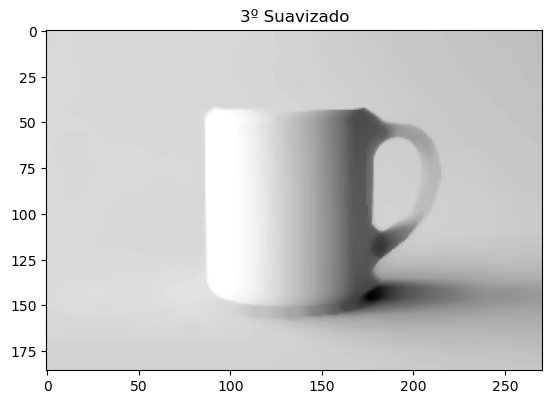

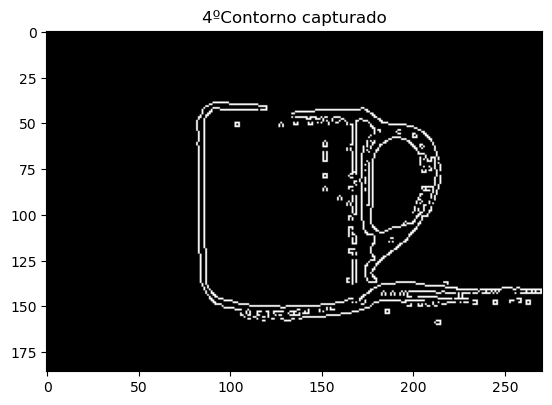

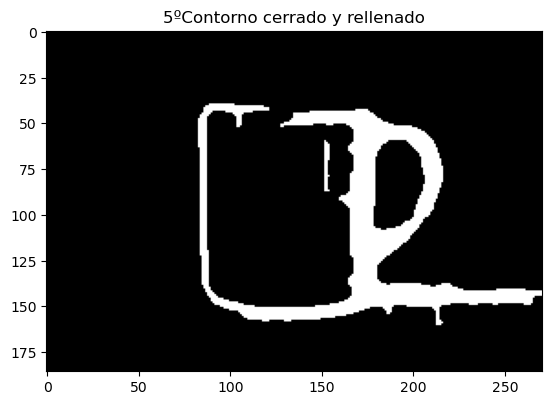

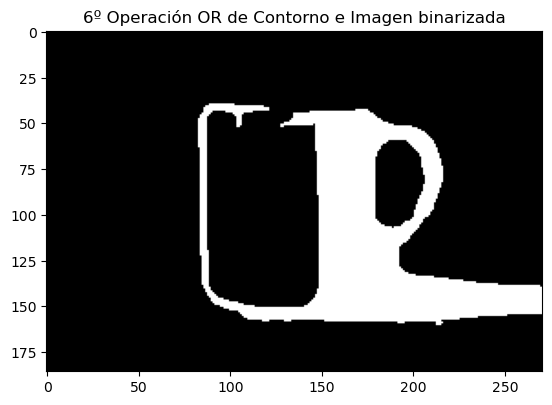

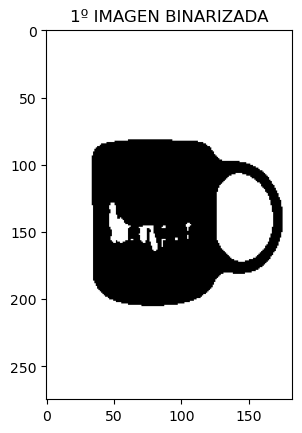

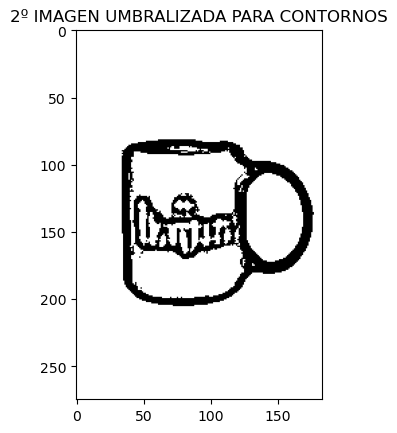

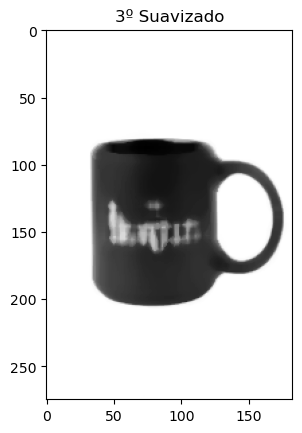

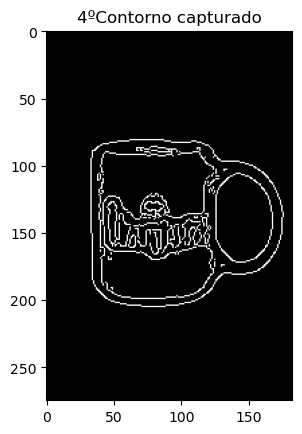

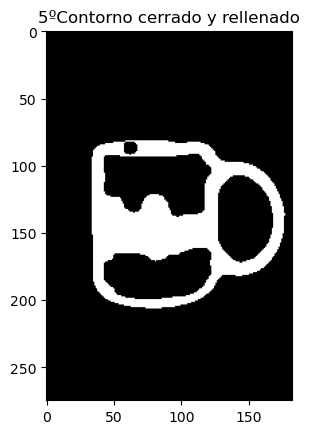

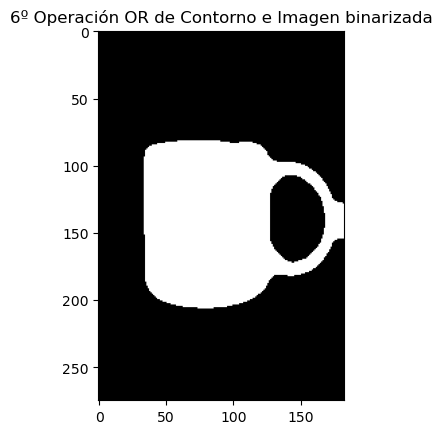

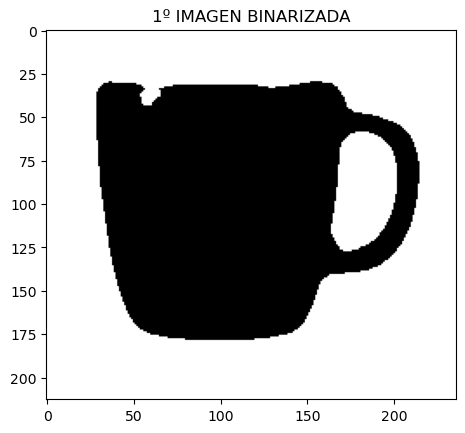

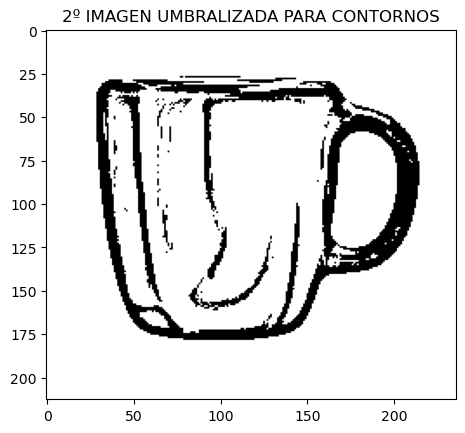

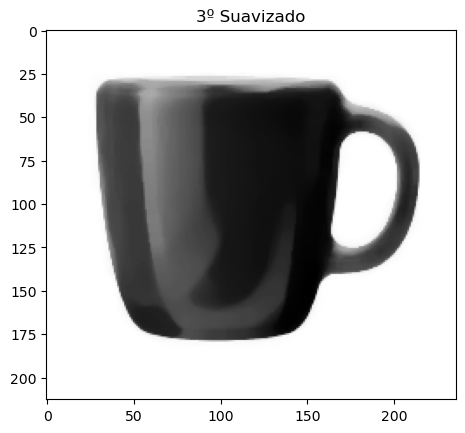

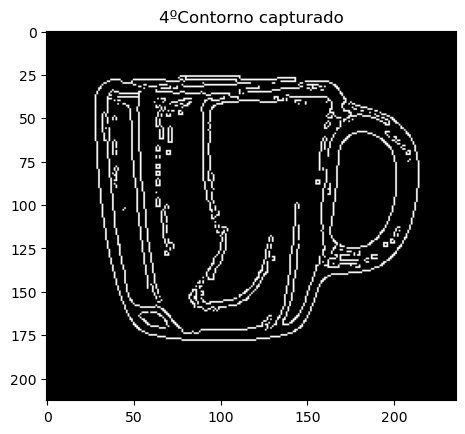

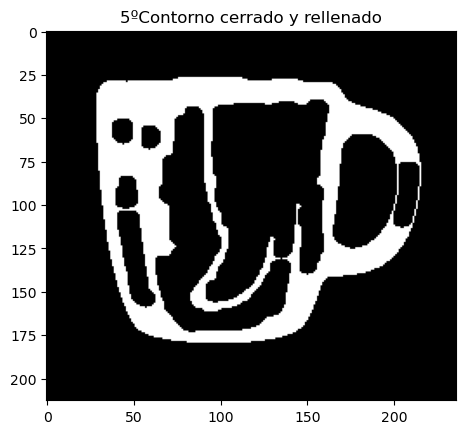

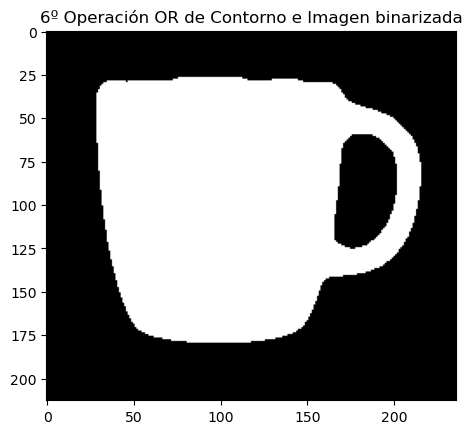

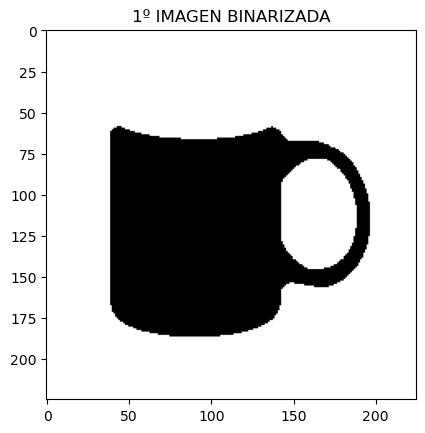

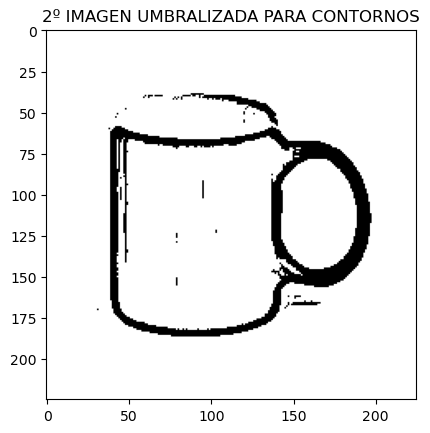

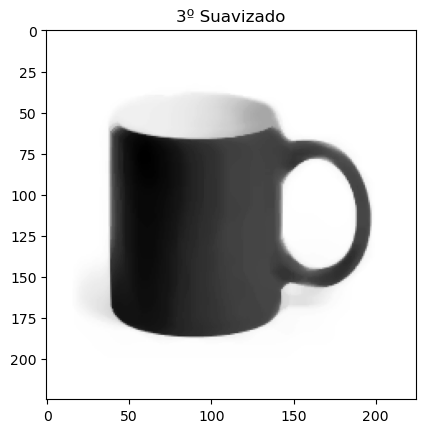

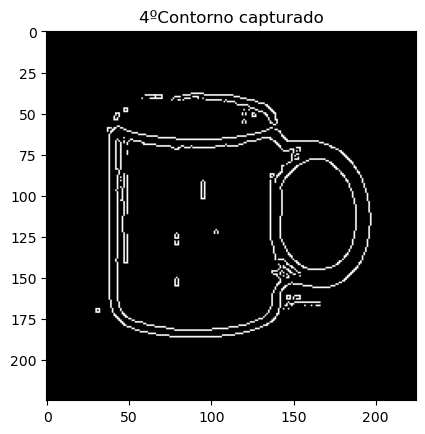

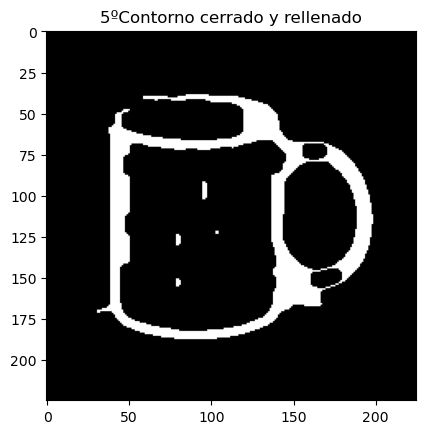

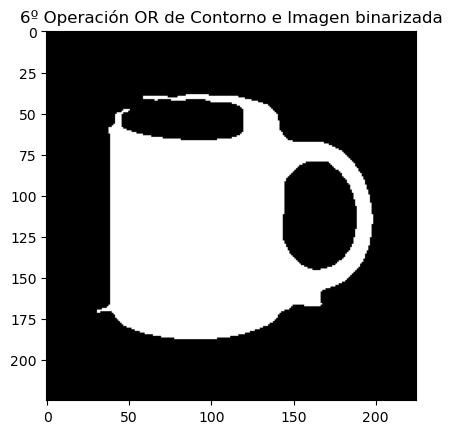

<Figure size 640x480 with 0 Axes>

In [7]:
data=get_silhouettes_from_input_folder("Tazas/",False,has_holes=True)
len(data)

In [ ]:
#HACER OPERACIÓN OR DE IMAGEN BINARIA  Y CONTORNO

Error: Las dimensiones de las imágenes no coinciden.


UnboundLocalError: local variable 'orr' referenced before assignment

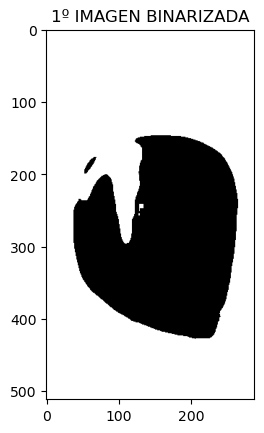

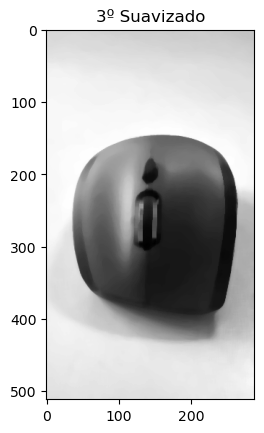

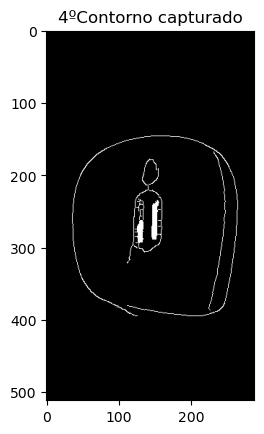

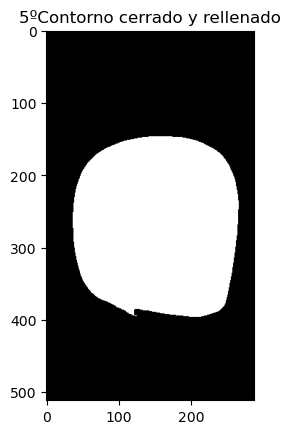

<Figure size 640x480 with 0 Axes>

In [15]:
data=get_silhouettes_from_input_folder("Photos/vistas/",True,False)


In [4]:
cv.imwrite("silueta1.jpg",data[2])
cv.imwrite("silueta2.jpg",data[3])
silueta1=cv.imread("silueta1.jpg")
silueta2=cv.imread("silueta2.jpg")

print(silueta1.shape)
print(silueta2.shape)


(512, 288, 3)
(512, 288, 3)


## Experimentaciones:

- **Aplicar realce de Laplance:** Al hacerlo después del suavizado,esto no sólo realzaba la figura, sino la imagen entera, por lo que a la hora de umbralizar hay partes de las imágenes que son detectadas que no pertenecen a la figura, por lo que tras aplicar varias transformaciones estas se expanden.**Conclusiones:** Obtener siluetas es sensible al realce de la imagen.


- **Operaciones de morfologías binarias:** A la hora de rellenar los contornos capturados era necesario completarlos y eliminar el ruido generado por la umbralización. Para eso, apliqué:
    - 1º Una erosión con un elemento estructural pequeño, ya que al ser demasiado grande, erosionaba la figura demasiado, y nosotros sólo lo queremos para eliminar el ruido sal que aparece. Esto no era aplicable con otro tipo de operación morfológica
    - 2º Un cierre con un elemento estructural grande, ya que nosotros queremos cerrar los contornos capturados, y al haber generalmente contornos muy alejados entre si, era necesario aplicar un elemento estructural grande (10,10). Devuelve buenos resultados, pero hay casos en los que al cerrar unimos contornos que no deberían unirse (como por ejemplo, sombras o ruidos restantes de la erosión).
**Conclusiones:* Erosionar poco es necesario para la generación de siluetas y útil para todos los casos, pero el cierre puede afectar mejor o pero dependiendo del caso, implicando que el tamaño del elemento estructural debe ser otro u es necesario algún paso extra para eliminar totalmente el ruido.

- **Probar con distintas formas:** Al principio, nuestro procesamiento sólo admitía figuras de género 0, pero esto reducía mucho el rango de objetos procesables. Para generar siluetas de género 1 o superior era necesario aplicar jerarquía a los contornos, pero esto hace que el procesamiento se haga más sensible al ruido de la umbralización, por lo que fue necesario aplicar la umbralización adaptativa para obtener la mejor umbralización posible. Además, al tener en cuenta la jerarquía, esto implica que si las figuras presentan obstaculos como colores diferentes al propio objeto, ya sean letras de una taza o un dibujo, esto haría que los contornos de estos obstaculos que se encuentran en el interior del objeto dificulten la correcta generación de la silueta. **Conclusiones:** El procesamiento de figuras de grado 1 o superior se complica cuanto más detalles internos el objeto tenga.


- **Niveles de gris del objeto y el contorno:** A la hora de detectar los interiores de figuras de grado 1 o superior, se puede dar el caso de que presente un nivel de gris similar a la del background, haciendo que a la hora de umbralizar interprete estos interiores como parte del entorno, afectando al procesamiento de las siluetas. **Conclusión:** El nivel de gris del objeto y de su interior si es similar a la del entorno, le será dificil al proceso de umbralización sacar la binarización correcta. 

In [ ]:
###TODO= EXPERIMENTACIÓN SOBRE LOS COLORES. SI NO ES LUZ BLANCA NO VA A FUNCIONAR. COMO SE PODRIA MEJORAR.
###TODO= ALGPORITMO DE SILUETAS SE CAMBIO PARA PODER DETECTAR EL CUBO DE RUBIC.

##TODO= CONCLUSIONES Y MEJORAS

#TODO: PARA EL MANUAL DE USUARIO, INCLUIRLO TODO: cosas a instalar, que cosas hacer,....

